This is the implementation of UNet with padded convolutions.
In contrast to the original paper, the shape of input and output images as well as
all of the middle feature maps are compatible and we do not need to crop feature
maps for skip connection. This will simplify the implementation and functionality.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Carvana Dataset'

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as F

# device = "cuda" if torch.cuda.is_available() else "cpu" # for Google Colab
device = "mps" if torch.backends.mps.is_available() else "cpu" # for Apple Silicon

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, residual=False):
        self.residual = residual
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels,
                               out_channels=out_channels,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        residual = out
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        if self.residual:
            return out + residual
        else:
            return out


class UNet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 features=[64, 128, 256, 512],
                 residual=False,
                 attention=False):

        self.residual = residual
        self.attention = attention

        super(UNet, self).__init__()

        self.contracting_path = nn.ModuleList()
        self.expanding_path = nn.ModuleList()
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

        # Contracting path of the UNet
        for feature in features:
            self.contracting_path.append(DoubleConv(in_channels=in_channels,
                                                    out_channels=feature,
                                                    residual=self.residual))
            in_channels = feature

        # Expanding path of the UNet
        for feature in reversed(features):
            self.expanding_path.append(nn.ConvTranspose2d(in_channels=feature*2,
                                                          out_channels=feature,
                                                          kernel_size=2,
                                                          stride=2))
            self.expanding_path.append(DoubleConv(in_channels=feature*2,
                                                  out_channels=feature,
                                                  residual=self.residual))

        self.bottleneck = DoubleConv(in_channels=features[-1],
                                     out_channels=features[-1]*2,
                                     residual=self.residual)

        self.final_conv = nn.Conv2d(in_channels=features[0],
                                    out_channels=out_channels,
                                    kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down_block in self.contracting_path:
            x = down_block(x)
            skip_connections.append(x)
            x = self.pooling(x)

        x = self.bottleneck(x)

        # Now, we reverse the `skip_connection` list since we are going from down to up in expanding path.
        skip_connections = skip_connections[::-1]

        # While creating `self.expanding_path`, we appened two processing to the input
        # That is why we use step of two in the next line of code.
        for idx in range(0, len(self.expanding_path), 2):
            x = self.expanding_path[idx](x)
            skip_connection = skip_connections[idx//2]

            # The next two lines are for the case that the input image shape is not perfectly
            # devisible by 16 and it will make a size mismatch while concatenating x and skip_connection
            if x.shape != skip_connection.shape:
                x = F.resize(x, size=skip_connection.shape[2:])

            if self.attention:
                attention_model = Attention(gate=x, skip_connection=skip_connection).to(device)
                attention_map = attention_model()
                attentive_skip = torch.mul(attention_map, skip_connection)
                self.final_attection_map = attention_map # for visualization
                output = torch.cat((attentive_skip, x), dim=1)
            else:
                output = torch.cat((skip_connection, x), dim=1)
            x = self.expanding_path[idx+1](output)

        return self.final_conv(x)

class Attention(nn.Module):
    def __init__(self, gate, skip_connection):
        self.gate = gate
        self.skip_connection = skip_connection
        self.num_channels = gate.shape[1] # in this srchitecture, skip_connection and gate have the same shape

        super(Attention, self).__init__()

        self.atten_conv1 = nn.Conv2d(in_channels=self.num_channels,
                                    out_channels=self.num_channels,
                                    kernel_size=1,
                                    stride=1,
                                    padding=0,
                                    bias=False)
        self.bn1 = nn.BatchNorm2d(self.num_channels)
        self.atten_conv2 = nn.Conv2d(in_channels=self.num_channels,
                                    out_channels=1, # to creat the attention map
                                    kernel_size=1,
                                    stride=1,
                                    padding=0,
                                    bias=False)
        self.bn2 = nn.BatchNorm2d(1)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self):

        g = self.bn1(self.atten_conv1(self.gate))
        x = self.bn1(self.atten_conv1(self.skip_connection))

        psi = self.relu(g + x)
        sigma = self.bn2(self.atten_conv2(psi))

        attention_map = self.sigmoid(sigma)

        return attention_map


def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNet(in_channels=1, out_channels=1, attention=True)
    preds = model(x)
    print (preds.shape)
    print (x.shape)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


In [4]:
import torch
from tqdm import tqdm

def train_fn(loader, model, optimizer, loss_fn, device):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):

        data = data.to(device=device)
        targets = targets.float().unsqueeze(1).to(device=device)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class CarvanaDataset(Dataset):
    def __init__(self,
                 image_dir,
                 mask_dir,
                 transform=None):

        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        """Next line of code is for disregarding `.DS_Store` in Mac"""
        self.images = [filename for filename in os.listdir(image_dir) if filename != '.DS_Store']


    def __len__(self):

        return len(self.images)

    def __getitem__(self, index):

        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) # converting to gray scale

        mask[mask == 255.0] = 1.0 # making the mask binary for the softmax output of the network

        # The same transformation from the `albumentations` library will be applied on images and masks.
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


In [45]:
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

def save_checkpoint(state, filename=root_path+"/checkpoints/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_dir, train_maskdir,
                val_dir, val_maskdir,
                batch_size,
                train_transform, val_transform):

    train_ds = CarvanaDataset(image_dir=train_dir,
                              mask_dir=train_maskdir,
                              transform=train_transform)

    train_loader = DataLoader(train_ds,
                              batch_size=batch_size,
                              shuffle=True)

    val_ds = CarvanaDataset(image_dir=val_dir,
                            mask_dir=val_maskdir,
                            transform=val_transform)

    val_loader = DataLoader(val_ds,
                            batch_size=batch_size,
                            shuffle=False)

    return train_loader, val_loader

def check_accuracy(loader, model, device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

    return dice_score/len(loader)

def save_predictions_as_imgs(loader, model, folder, device):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

        model.train()

In [7]:
import albumentations as A # pip install albumentations
from albumentations.pytorch import ToTensorV2

def transforms(image_height, image_width):

    train_transform = A.Compose(
            [
                A.Resize(height=image_height, width=image_width),
                A.Rotate(limit=35, p=1.0),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.1),
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )

    val_transforms = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    return train_transform, val_transforms

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

def plot_attention_map_grid(attention_maps, num_rows, num_columns, x_label=None, y_label=None):
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 3))
    plt.subplots_adjust(wspace=0.05, hspace=-0.21)  # Adjust spacing between subplots

    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            ax = axs[i, j]

            if len(attention_maps[index].shape) == 2:
                im = ax.imshow(attention_maps[index], cmap='RdBu_r', interpolation='nearest', aspect='auto')
            else:
                im = ax.imshow(attention_maps[index][0], cmap='RdBu_r', interpolation='nearest', aspect='auto')

            # Set axes with equal metrics
            ax.set_aspect('equal')
            ax.axis('off')  # Turn off axis labels and ticks

    # Add a smaller colorbar to the right of the grid
    cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax)

    plt.show()

cuda
Got 1485585/1843200 with acc 80.60
Dice score: 0.0


100%|██████████| 158/158 [06:10<00:00,  2.35s/it, loss=0.17]


Got 1821782/1843200 with acc 98.84
Dice score: 0.9702726006507874
=> Saving checkpoint


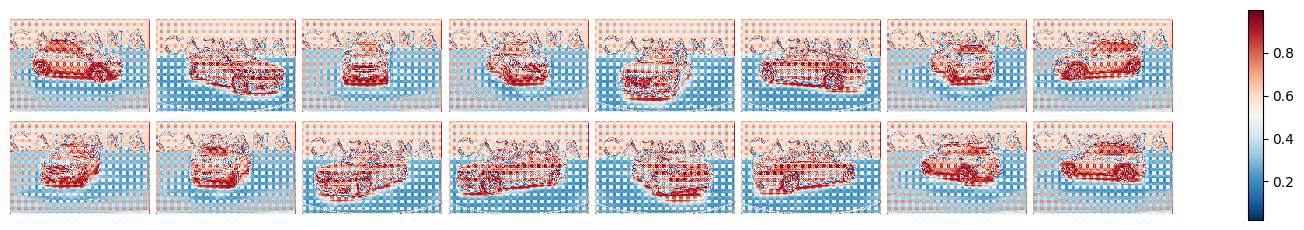

In [44]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu" # for Google Colab
# device = "mps" if torch.backends.mps.is_available() else "cpu" # for Apple Silicon
print(device)

# Creating directories for saving model's checkpoints and also performance in terms of images
os.makedirs(root_path+"/checkpoints/", exist_ok=True)
os.makedirs(root_path+"/saved_images/", exist_ok=True)

learning_rate = 1e-4
batch_size = 32
num_epochs = 1
image_height = 160  # 1280 originally
image_width = 240   # 1918 originally
load_model = False
train_img_dir = root_path+"/train_images/"
train_mask_dir = root_path+"/train_masks/"
val_img_dir = root_path+"/val_images/"
val_mask_dir = root_path+"/val_masks/"

model = UNet(in_channels=3, out_channels=1, attention=True).to(device)

"""
`BCEWithLogitsLoss` applies Sigmoid activation over the final layer and calculates the nn.BCELoss.
It is often preferred over applying a Sigmoid activation in the model and then using nn.BCELoss.
This preference is due to the numerical stability and efficiency of the training procedure.
"""
loss_fn = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_transform, val_transform = transforms(image_height=image_height,
                                            image_width=image_width)

train_loader, val_loader = get_loaders(train_dir=train_img_dir,
                                       train_maskdir=train_mask_dir,
                                       val_dir=val_img_dir,
                                       val_maskdir=val_mask_dir,
                                       batch_size=batch_size,
                                       train_transform=train_transform,
                                       val_transform=val_transform)

if load_model:
    load_checkpoint(torch.load(root_path+"/checkpoints/epoch1_checkpoint.pth.tar"), model)

dice_buffer = check_accuracy(val_loader, model, device=device)

for epoch in range(num_epochs):
    train_fn(train_loader, model, optimizer, loss_fn, device)

    dice_score = check_accuracy(val_loader, model, device=device)

    if dice_score > dice_buffer:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=root_path+"/checkpoints/checkpoint.pth.tar")
        dice_buffer = dice_score

    save_predictions_as_imgs(val_loader, model, folder=root_path+"/saved_images/", device=device)


    attention_map = model.final_attection_map.view(-1, 160, 240).cpu().numpy()
    plot_attention_map_grid(attention_map, 2, 8)